# Homework 5: Taming Text

"Did you say *personal emails*, Madame the Secretary of State ?"

In this Homework, we are going to do some lexical analysis using the controversed emails of the Hillary Clinton, when she was Secretary of State.

# 0. Import the libraries, Read the data and check its form

We import the usual libraries. Note the libraries *WordCloud* or *nltk* which are going to be very useful for us in this exercise.

In [1]:
# Usual imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Specific imports
from wordcloud import WordCloud
import nltk

Let's define the path of the emails data:

In [2]:
# Some constants
mailPath = 'hillary-clinton-emails/Emails.csv'

And we read them:

In [3]:
# Read data
df_emails = pd.read_csv(mailPath, sep=',')
# Columns available
df_emails.columns

Index(['Id', 'DocNumber', 'MetadataSubject', 'MetadataTo', 'MetadataFrom',
       'SenderPersonId', 'MetadataDateSent', 'MetadataDateReleased',
       'MetadataPdfLink', 'MetadataCaseNumber', 'MetadataDocumentClass',
       'ExtractedSubject', 'ExtractedTo', 'ExtractedFrom', 'ExtractedCc',
       'ExtractedDateSent', 'ExtractedCaseNumber', 'ExtractedDocNumber',
       'ExtractedDateReleased', 'ExtractedReleaseInPartOrFull',
       'ExtractedBodyText', 'RawText'],
      dtype='object')

We observe that the data are pretty complex, and not all the information will be useful for us in this homework. Let's observe specifically the columns *ExtractedSubject*, *ExtractedBodyText* and *RawText*.

In [4]:
df_emails[['ExtractedSubject', 'ExtractedBodyText', 'RawText']].head(6)

,ExtractedSubject,ExtractedBodyText,RawText
0,FW: Wow,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
1,NaN,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
2,Re: Chris Stevens,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
3,FVV: Cairo Condemnation - Final,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,NaN,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...
5,Meet The Right Wing Extremist Behind Anti-Musl...,Pis print.\n-•-...-^\nH < hrod17@clintonernail...,B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


We observe that some *ExtractedSubject* and *ExtractedBodyText* entries are filled with NaN. We will see their impact bellow.

# 1. Word Cloud Generation

Let's try to create a WordCloud image to observe which are the words most used by the Secretary of State in her emails. We construct the WordCloud on the unmodified data first.

Let's define a function that concatenate the emails text into one single string in order to respect wordcloud input requires:

In [5]:
def concatenate_emails(dataFrame):
    text_tuple = list(dataFrame.ExtractedBodyText) + list(dataFrame.ExtractedSubject)
    
    text = " ".join(str(s) for s in text_tuple)
    text = text.replace('\n', ' ')
    text = text.replace('\'', '"')

    return text

We need also to define a function that create and plot correctly a wordcloud:

In [6]:
def plot_wordcloud(text, max_font_size=None, background_color=None, max_words=None, mask=None, stopwords=None):
    wordcloud = WordCloud(max_font_size=max_font_size)
    wordcloud.generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [7]:
text_raw = concatenate_emails(df_emails)

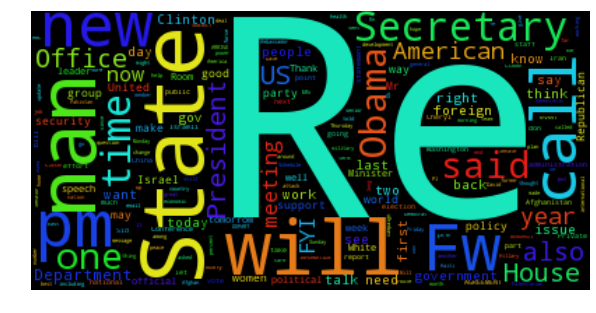

In [8]:
plot_wordcloud(text_raw)

We can have multiple comments on this image: First, we observe that some relevant words seem to appears many times as the words *State*, *Obama* or *Secretary*. This is good and not really surprising coming from the email of the Secretary of State during Obama mandat. However, we also see some unrelevant words as for example: *Re* which is generated automatically by the mailbox when one responds to an email, and the word *nan* which is coming from the DataFrame to inform us that no data are available for a specific entry. Thus, we need to clean and pre-process the text in order to get rid of all this useless and wrong information.

For the cleaning process, we are going to go trough the following steps:
* **Tokenization**
* **Stopword removal**
* **Lemmatization**
* **Stemming**

## 1.1 Tokenization

First, let's tokenize the emails text we have. Here is the [Wikipedia](https://en.wikipedia.org/wiki/Tokenization) definition of tokenization for Data and lexical Analysis purpose:

> *In lexical analysis, tokenization is the process of breaking a stream of text up into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing such as parsing or text mining.*

We tokenize each words of the text in order to remove the irrelevant ones in further process, i.e *Stopword removal*.

In [9]:
# Tokenization
tokens_raw = nltk.regexp_tokenize(text_raw, pattern='\w+')

# Normalization
tokens_norm = [t.lower() for t in tokens_raw]

# Removing the numbers
tokens_without_digits = [t for t in tokens_norm if t.isdigit() == False]

tokens_without_digits[:10]

['nan', 'b6', 'thursday', 'march', 'pm', 'h', 'latest', 'how', 'syria', 'is']

We can take more tokens, e.g. also the dollar signs which might also be relevant to show the attitude towards a country. However, it can be both positive or negative and it will be difficult to identify this (a simple 'not' can invert the situation), so we just put it for illustration here.

In [10]:
# Tokenization, also take money into account
tokens_raw2 = nltk.regexp_tokenize(text_raw, pattern='\w+|\$[\d\.]+')

# Normalization
tokens_norm2 = [t.lower() for t in tokens_raw2]

# Removing the numbers
tokens_without_digits2 = [t for t in tokens_norm2 if t.isdigit() == False]

tokens_without_digits2[:10]

differenceWithMoney = set(tokens_without_digits2).difference(set(tokens_without_digits))
for i, elem in enumerate(differenceWithMoney):
    if i>= 10:
        break
    else:
        print(elem, end=", ")

$85, $251, $250, $8, $125, $12, $11, $7.9, $37, $7.5, 

We observe that we could successfully separate each word in different tokens, but we still need to remove the irrelevant words with the *Stopword removal* process.

## 1.2 Stopword removal

The role of this step is to remove from the tokens all the words that do not bring us more interesting information and thus pollute the analysed text. First, let's define which words are considerated as stopword.

First we download the already predefined stopwords from the *nltk* library:

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/maximilian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/maximilian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/maximilian/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Then, we can add to the list, the stopword specifically defined for emails, i.e *re*, *to*, *pm* for examples.

In [12]:
emails_stop_words = ['nan', 're', 'fw', 'fwd', 'fvv', 'fyi', 'fm', 'h','pm','docx', 
                     'n\'t', 'sent', 'from', 'to', 'subject', 'cc', 'bcc', 'attachments', 
                     'html', 'php', 'b6', '4g']

stop_words = set(stopwords.words('english'))
stop_words.update(emails_stop_words)
print(stop_words)

{'pm', 'cc', 'mightn', 'me', 'nan', 'and', 'to', 'them', 'ma', 'b6', 'mustn', 'did', 'about', 'out', 'd', 'or', 'needn', 'those', 'by', 'during', 'wouldn', 'should', 'why', 'i', 'bcc', 'few', 'for', 'being', 'not', 'am', 'o', 'won', 'll', 'such', 'into', 'through', 'shan', 'he', 'more', 't', 'are', 'than', 'it', 've', 'theirs', 'isn', 'an', 'hasn', 'doing', 'fyi', 'against', 'will', 'of', 'other', 'at', 's', 'themselves', 'before', 'we', 'which', 'that', 'sent', 'ours', 'be', 'there', 'but', 'after', 'herself', 'nor', 'html', 'the', 'a', 'her', 'most', 'hadn', 'yourself', 'him', 'ourselves', 'from', 'in', 'how', 'whom', 'hers', 'm', 'his', "n't", 'under', 're', 'she', 'over', 'very', 'again', 'himself', 'because', 'own', 'itself', 'when', 'too', 'ain', 'h', 'further', 'my', 'same', 'fw', 'now', 'myself', 'do', 'does', 'php', 'fm', 'had', 'no', 'couldn', 'yourselves', 'aren', 'have', 'didn', 'some', 'their', 'while', 'who', 'its', 'doesn', 'down', 'if', 'your', 'both', 'on', 'below', 'a

Let's now get rid of theses stopwords in the tokens previously computed. We note that some tokens have been correctly removed.

In [13]:
tokens_without_stopword = [t for t in tokens_without_digits if t not in stop_words]
tokens_without_stopword[:10]

['thursday',
 'march',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 'sid',
 'hrc',
 'memo',
 'syria']

We can remark as well that there is still some *noisy words* in the tokens. For example, if we check the tokens with a length equal to 1, which correspond to a single letter or symbol alone, we observe that we get multiple noisy tokens that have not been removed. 

In [14]:
token_short = [t for t in tokens_without_stopword if len(t) == 1]
token_short[:10]

['u', 'f', 'k', 'u', 'f', 'u', 'f', 'u', 'f', 'u']

In [15]:
len(token_short)

4375

Therefore, we can remove as well theses useless words from our list of tokens.

In [16]:
tokens_cleaned = [t for t in tokens_without_stopword if len(t) > 1]
tokens_cleaned[:10]

['thursday',
 'march',
 'latest',
 'syria',
 'aiding',
 'qaddafi',
 'sid',
 'hrc',
 'memo',
 'syria']

## 1.3 Lemmatization

In order to obtain even better result, we can also *lemmatize* our tokens. The lemmatization process consists in transforming and regrouping the words of a similar origin to its easiest form. For examples, the words *boys* and *boy* or *similarities* and *similarity*, previously stored in four different tokens, will now be only stored in two, say *boy* and *similarity*. For doing the lemmatization, we will use a predefine function from the *nltk* library.

In [17]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
tokens_lemmatized = [wnl.lemmatize(t) for t in tokens_cleaned]

With theses processing, let's rebuild a wordcloud image and observe what are the notable differences so far. First, we need to define a function to concatenate the tokens together. 

(The function is very simple but it is clearer to define it as a function, because we are going to use the same code multiple times in this exercise.)

In [18]:
def concatenate_tokens(tokens):
    text = " ".join(t for t in tokens)
    return text

In [19]:
text_lemmatized = concatenate_tokens(tokens_lemmatized)

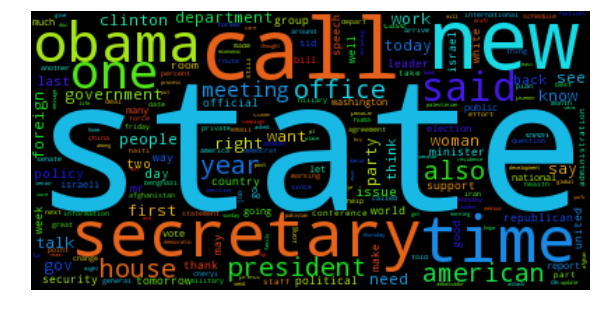

In [20]:
plot_wordcloud(text_lemmatized)

As we expected, we can observe now that all the *noisy words* previously seen in the wordcloud, as *'nan'*, *'Re'*, *'Fw'* or *'pm'* , have been removed, which let place to much more relevant words as *'state'*, *'call'* or *'secretary'* for examples.

## 1.4 Stemming

One other processing that can improve the performances is to do stemming on the tokens. The stemming process delete the sufixes of some words in order to regroupe words from the same family into one unique token. For example, *automate(s)*, *automatic*, *automation* will all be reduced to *automat*. It reduces the words to their roots. Thus, the token *example* will become *exampl*.

In [21]:
from nltk.stem.porter import *

stemmer = PorterStemmer()
tokens_stemmed = [stemmer.stem(t) for t in tokens_lemmatized]

We can observe now what are the impacts of the stemming processus, by looking at the wordcloud image generated with the new tokens.

In [22]:
text_stemmed = concatenate_tokens(tokens_stemmed)

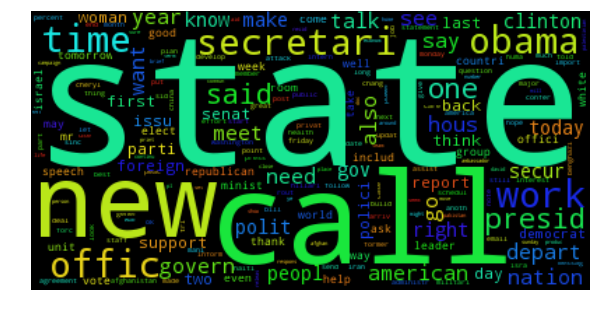

In [23]:
plot_wordcloud(text_stemmed)

The first comment we can make on this new image is that the word *call* has now more importance than on the previous image. This is due to the fact that words like *calling* or *called* are now regroup into a single *call* token. We also can see the impact of the stemming process by looking at the tokens *office* and *secretary* that became respectively *offic* and *secretari*.

The processus seems to have been benefical for the results because we can see now more relevant tokens appearing as *govern* or *republican*. On the contrary, not interesting tokens like *one* or *time* have less importance.

# 2. Popularity of Counties

For this second part, we are now going to analyze the popularity of the countries through the emails that have been send and received by the Secretary of State. 

For that, we are first going to determine the *polarity sentiment* of each email using `nltk.sentiment.vader` module. This module will give a score between -1 and 1 for each email. This score represents the general sentiment of the text, i.e if the score if close to 1, the text give a good general impression, and in contrary if the score is negative, the general feeling is bad.


We will then check the occurence of each country in the whole emails, using the external library: `pycountry`. Each time a country is mentioned in an email, whether it is its entire name (i.e. "Afghanistan") or its abbreviations (i.e. "AF" or "AFG"), we will store the *polarity sentiment* of this eamil and check at the end the average *polarity sentiment* of each country.

The objective is to draw a histogram (ordered and colored by polarity level) that summarizes US government perception of the different countries.

The first step is to construct a DataFrame with the emails (subject + text) and store their *polarity sentiment* using `nltk.sentiment.vader` module.

In [51]:
# We create the DataFrame
df_emails.fillna(' ', inplace=True)
df_emails_sentiment = pd.DataFrame(index=range(df_emails.shape[0]),columns=['email text', 'polarity sentiment'])
df_emails_sentiment['email text'] = df_emails['ExtractedSubject'] + ' ' + df_emails['ExtractedBodyText']
df_emails_sentiment.fillna(0, inplace = True) # fill in the polarity
df_emails_sentiment.head(10)

,email text,polarity sentiment
0,FW: Wow,0
1,"B6\nThursday, March 3, 2011 9:45 PM\nH: Late...",0
2,Re: Chris Stevens Thx,0
3,FVV: Cairo Condemnation - Final,0
4,"H <hrod17@clintonemail.com>\nFriday, March 1...",0
5,Meet The Right Wing Extremist Behind Anti-Musl...,0
6,"FW: Anti-Muslim film director in hiding, follo...",0
7,"H <hrod17@clintonemail.corn>\nFriday, March ...",0
8,FVV: Secretary's remarks FYI,0
9,"more on Libya B6\nWednesday, September 12, 201...",0


We can note that the email texts are not usable yet. They need to be cleaned and preprocessed in order to be analyzed.

We can thus define two functions:
* One to get the tokens of an email after some cleaning process presented in the first part.
* One to reform theses cleaned tokens into a sentence, which will be considered as the cleaned email.

In [52]:
number_of_emails = df_emails_sentiment.shape[0]

In [53]:
# Function to get the cleaned tokens of an email
def get_cleaned_tokens_from_email(email_text):
    
    # Tokenize
    email_tokens_raw = nltk.regexp_tokenize(email_text, pattern='\w+')
    email_tokens_without_digits = [t for t in email_tokens_raw if t.isdigit() == False]
    
    #Stopwords removal
    email_tokens_without_stopword = [t for t in email_tokens_without_digits if t.lower() not in stop_words]
    email_tokens_long = [t for t in email_tokens_without_stopword if len(t) > 1]
    
    #Lemmatize
    email_tokens_lemmatized = [wnl.lemmatize(t) for t in email_tokens_long]

    return email_tokens_lemmatized

In [54]:
# Function to reconstruct the email based on the cleaned tokens
def clean_email_text(email_text):
    
    # Processing email text
    email_tokens_cleaned = get_cleaned_tokens_from_email(email_text)
    
    # Reconstruct the sentence
    cleaned_email_text = " ".join(t for t in email_tokens_cleaned)
   
    return cleaned_email_text

Let's observe the DataFrame after the cleaning process. We see that the data are much more usable now.

In [55]:
df_emails_sentiment['email text'] = df_emails_sentiment['email text'].apply(lambda x: clean_email_text(x))
df_emails_sentiment.head(10)

,email text,polarity sentiment
0,Wow,0
1,Thursday March Latest Syria aiding Qaddafi Sid...,0
2,Stevens,0
3,Cairo Condemnation Final,0
4,hrod17 Friday March Huma Abedin Latest Syria a...,0
5,Right Wing Extremist Anti Muslim Film Sparked ...,0
6,Anti Muslim film director hiding following Lib...,0
7,hrod17 corn Friday March Huma Abedin Latest Sy...,0
8,remark,0
9,Libya Wednesday September libya Libya sept Sen...,0


We will now perfom the sentiment analysis using a *SentimentIntensityAnalyzer* imported from the module *nltk.sentiment.vader*, in order to determine the *polarity sentiment* of each email.

Let's first import the library (before run 'pip install twython'):

In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

We can test the analyzer with two simple sentences to see if it works correctly. We observe that we get results as we could expect.

In [57]:
sia = SentimentIntensityAnalyzer()
sentiment = sia.polarity_scores('I love you')['compound']
print(sentiment)
sentiment = sia.polarity_scores('I hate you')['compound']
print(sentiment)

0.6369
-0.5719


In [58]:
# Function that perform the sentiment analysis for one specific email (at ith row) 
# in the dataFrame
def fill_email_sentiment (iRow, dataFrame):
    email = dataFrame.get_value(iRow, 'email text')
    sentiment = sia.polarity_scores(email)['compound']
    dataFrame.loc[iRow, 'polarity sentiment'] = sentiment
    return

In [59]:
# Function to perform the sentiment analysis of all the mails in the dataFrame
def fill_sentiment_dataFrame(dataFrame):
    print('Start processing...')
    for iRow in range(number_of_emails):
        fill_email_sentiment(iRow, df_emails_sentiment)
        if iRow % 1000 == 0:
            print(iRow)
    print('Finished!')

With the use of the two functions above, we can determine the *polarity sentiment* of all the emails. Let's check the results obtained. **Warning:** The processus takes a few minute to compile!

In [ ]:
## WARNING: This cell takes a few minutes to compile ##
fill_sentiment_dataFrame(df_emails_sentiment)

In [ ]:
df_emails_sentiment.head(8)

We observe that the *polarity sentiment* entries have been correctly implemented. Note also that some entries are still equal to zero. This is the case when the analyzer could not determine any sentiment or maybe if there is some positive and negative impression inside a unique email, which are equally weighted.

##### TODO COMMENT: remove this already done above

In [ ]:
emails_tokens = []
for iRow in range(number_of_emails):
    email = df_emails_sentiment.loc[iRow,'email text']
    tokens = get_cleaned_tokens_from_email(email)
    emails_tokens.append(tokens)

First let's import the library *pycountry* that we are going to use for defining the countries, as well as the module *nltk.sentiment.vader* to determine the sentimental perception of a text, i.e an email.

In [ ]:
# run 'pip install pycountry'
import pycountry

countries = [country for country in list(pycountry.countries)]
countries_names = [country.name for country in countries]

Let's see what the attributes are:

In [ ]:
dir(countries[1])

In [ ]:
countries[1].name

In [ ]:
countries[1].alpha_2

In [ ]:
countries[1].alpha_3

In [ ]:
countries_names[:10]

Let's define now a function that check the occurence of a specific list of countries in the emails, i.e in the tokens, and if the countries appear at least once in the text, add it to a DataFrame passed as argument. 

Note that we are going to use here the lemmatized tokens, but ***not*** the tokens after the stemming process, because we don't want the country names been changed. Using the stemmed tokens can also bias our results, because the stemming process will work only for some specific countries. For example, *australian* will be assigned to *australia* but *swiss* and *switzerland* will not be recognize as the same.

Now let's define the functions:
We define a function to put in place the dataframe that counts the number of times a country occurs in each email as well as the total polarity. We normalize it by dividing by the number of countries to get an average polarity per country. Observe that a country is not counted more than once per email.

In [ ]:
def initialize_dataFrame_countries():
    df = pd.DataFrame(index=countries_names, 
                      columns=['occurences', 
                               'polarity sentiment', 
                               'normalized polarity sentiment'])
    df.fillna(0, inplace=True)
    return df

In [ ]:
# searches for occurrences of 'country' in the email (characterized by tokens) and fills the dataframe
def find_country_and_sentiment_in_email(country, dataFrame, tokens):
    for iRow in range(len(tokens)):
        for token in tokens[iRow]:
            countryAppearsInToken = (
                token.lower() == country.name.lower() 
                or token == country.alpha_2 
                or token == country.alpha_3)
            if countryAppearsInToken:
                #dataFrame.set_value(country.name, 'occurences', dataFrame.get_value(country.name, 'occurences') + 1)
                dataFrame.loc[country.name, 'occurences'] += 1
                
                email_sentiment = df_emails_sentiment.get_value(iRow, 'polarity sentiment')
                dataFrame.loc[country.name, 'polarity sentiment'] += email_sentiment
                
                continue # we don't want to count the country more than once per email
                
    return

In [ ]:
def initialize_and_fill_dataFrame_countries(tokens):
    df = initialize_dataFrame_countries()
    
    print('Processing...')
    
    for i, country in enumerate(countries, start=1):
        find_country_and_sentiment_in_email(country, df, tokens)
        
        if(i/len(countries) > 0.25 and i/len(countries) < 0.255):
            print('25%')
        
        if(i/len(countries) > 0.50 and i/len(countries) < 0.505):
            print('50%')
            
        if(i/len(countries) > 0.75 and i/len(countries) < 0.755):
            print('75%')
    
    df = df[df['occurences'] != 0]
    
    print('Finished!')
    return df

In [ ]:
# take the average per country
def normalize_polarity_sentiments(dataFrame):
    dataFrame['normalized polarity sentiment'] = dataFrame['polarity sentiment']/dataFrame['occurences']

In [ ]:
## WARNING: This cell takes a few minutes to compile ##
df_countries = initialize_and_fill_dataFrame_countries(emails_tokens)
normalize_polarity_sentiments(df_countries)

In [ ]:
df_countries_most_mentioned = df_countries[df_countries['occurences'] > 20]
df_countries_most_mentioned.sort('occurences', inplace=True)
df_countries_most_mentioned.head(10)

In [ ]:
palette = sns.color_palette("RdYlGn", n_colors = df_countries_most_mentioned.shape[0])
plt.rcParams['figure.figsize'] = (10.0, 8.0)
df_countries_most_mentioned['normalized polarity sentiment'].sort_values().plot(kind="bar", color=palette);

##### TODO: I don't understand what to do here, should we rerun the sentiment analysis above, i.e. in function fill_email_sentiment, use something different than sia.polarity_scores

# 3. Topic Modelling

In [24]:
# TODO
# run 'pip install gensim', 'pip install pyLDAvis'
from gensim import corpora
from gensim import models
import pyLDAvis
import pyLDAvis.gensim as gensimvis

/home/maximilian/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")
/home/maximilian/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/maximilian/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/maximilian/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
/home/maximilian/anaconda3/lib/python3.5/site-packages/funcy/decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signa

#### TODO: explain how we got 'stoplist_final.txt'

In [25]:
# Creation of the stop words
stop_words = set(stopwords.words('english'))

new_stop_words = []
with open('stoplist_final.txt', 'r') as f:
    new_stop_words = f.read().splitlines()

stop_words.update(emails_stop_words)
stop_words.update(new_stop_words)

new_stop_list2 = ['would','today','u','e','thx','said','see','new','one','mr','like','us','call','fyi','yet','also','work','time','get','want','like','w','en',
                 'get','talk', 'b', 'think','tomorrow','know','j','g','good','sent','qqdr','let', 'gov','com','case','two','year', 'back','going','need','next',
                 'last','still','go','best','sure','pls','clintonemail','could','may','mtg','week','way','come','take','well','hope','told','send','make','print',
                 'f','doc','state','states','ap','says','people','obama','president','government','many','secretary','clinton','even','first','fm','working',
                 'house','thanks','called','meet','pis','local','date','department','meeting','ok','yes','much','list','mail','email','hrc','schedule']

stop_words.update(new_stop_list2)

In [184]:
def get_clean_mails():
    mails = []
    topics = df_emails.ExtractedSubject.values
    contents = df_emails.ExtractedBodyText.values
    n = len(contents)
    print(n)
    for i in range(n):
        if (pd.isnull(topics[i])):
            text = str(contents[i])
        elif(pd.isnull(contents[i])):
            text = str(topics[i])
        else:
            text = str(topics[i]) + ' ' + str(contents[i])
        
        # Tokenization
        tokens = nltk.regexp_tokenize(text, pattern='\w+')

        # Normalization
        tokens = [t.lower() for t in tokens]
        text = text.replace('\n', ' ')
        text = text.replace('\'', '"')

        # Removing the numbers
        tokens = [t for t in tokens if t.isdigit() == False]
        
        # Removing stop words
        tokens = [t for t in tokens if t not in stop_words]
        
        mails.append(tokens)
    
    return mails

In [185]:
def get_dictionary_and_corpus(mails):
    from collections import defaultdict
    frequency = defaultdict(int)
    for mail in mails:
         for token in mail:
            frequency[token] += 1

    mails = [[token for token in mail if frequency[token] > 1] for mail in mails]
    
    dictionary = corpora.Dictionary(mails)
    corpus = [dictionary.doc2bow(mail) for mail in mails]
    
    return dictionary, corpus

In [186]:
def display_ldamodel(dictionary, corpus, num_topics=5):
    ldamodel = models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dictionary)
    vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)
    return pyLDAvis.display(vis_data)

In [187]:
mails = get_clean_mails()
dictionary, corpus = get_dictionary_and_corpus(mails)

7945


In [188]:
display_ldamodel(dictionary, corpus, num_topics=5)

In [ ]:
display_ldamodel(dictionary, corpus, num_topics=10)

# 4. Communication Graph (BONUS)

In [ ]:
# TODO

In [60]:
#Import the modules
import networkx as nx # install with 'pip install networkx'
import community # install with 'pip install community'

In [61]:
df_emails.head(1)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,,"Sullivan, Jacob J <Sullivan11@state.gov>",,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED\nU.S. Department of State\nCase N...


In [63]:
emailReceiversPath = 'hillary-clinton-emails/EmailReceivers.csv'

In [64]:
df_receiversOfEmails = pd.read_csv(emailReceiversPath, sep=',')
df_receiversOfEmails.rename(columns={'PersonId': 'ReceiverPersonId'}, inplace=True)
df_receiversOfEmails.head(3)

,Id,EmailId,ReceiverPersonId
0,1,1,80
1,2,2,80
2,3,3,228


In [65]:
nbEmails = len(df_emails)
nbReceivers = len(df_receiversOfEmails)
df_emailSendersToReceivers = df_emails[['Id', 'SenderPersonId']].merge(df_receiversOfEmails[['EmailId', 'ReceiverPersonId']], left_on='Id', right_on='ReceiverPersonId', how='inner')

print("There are {} emails and {} receivers.".format(nbEmails, nbReceivers))
sizeMapSenderReceivers = len(df_emailSendersToReceivers)
print("The size of the map from senders to receivers has length {}.".format(sizeMapSenderReceivers))
assert(nbReceivers == sizeMapSenderReceivers)

There are 7945 emails and 9306 receivers.
The size of the map from senders to receivers has length 9306.


In [66]:
df_emailSendersToReceivers.head(3)

,Id,SenderPersonId,EmailId,ReceiverPersonId
0,4,32,2820,4
1,9,87,407,9
2,9,87,621,9


There are still some missing values when there is no sender, represented by ' '.

In [67]:
df_emailSendersToReceivers['SenderPersonId'].value_counts()
#df_emailSendersToReceivers['ReceiverPersonId'].value_counts()

32.0     6304
80.0     1253
          836
48.0      486
87.0      313
81.0       30
194.0      19
135.0      15
150.0      11
38.0        6
209.0       5
10.0        5
213.0       4
77.0        3
170.0       3
22.0        2
124.0       2
216.0       2
143.0       2
5.0         2
105.0       1
185.0       1
201.0       1
Name: SenderPersonId, dtype: int64

We remove the emails that have no sender person id or no receiver person id (second case actually never happens as expected).

In [68]:
def remove_rows_with_missing(df, column_name, missing_value):
    df = df[~(df[column_name] == missing_value)]
    return df

# We remove the emails that have no person id

df_emailSendersToReceivers = remove_rows_with_missing(df_emailSendersToReceivers, 'SenderPersonId', " ")
#df_emailSendersToReceivers = remove_rows_with_missing(df_emailSendersToReceivers, 'ReceiverPersonId', " ")

df_emailSendersToReceivers.head(3)

,Id,SenderPersonId,EmailId,ReceiverPersonId
0,4,32,2820,4
1,9,87,407,9
2,9,87,621,9


In [69]:
df_emailSendersToReceivers.head(3)

,Id,SenderPersonId,EmailId,ReceiverPersonId
0,4,32,2820,4
1,9,87,407,9
2,9,87,621,9


In [70]:
communityGraph = nx.from_pandas_dataframe(df_emailSendersToReceivers, 'SenderPersonId', 'ReceiverPersonId')

We do it similarly to http://perso.crans.org/aynaud/communities/api.html.

In [71]:
# compute the best partition
partition = community.best_partition(communityGraph)

In [78]:
totalNbCommunities = len(set(partition.values()))

print("There are {} communities".format(totalNbCommunities))

There are 13 communities


We plot the graph of the persons and the communities.

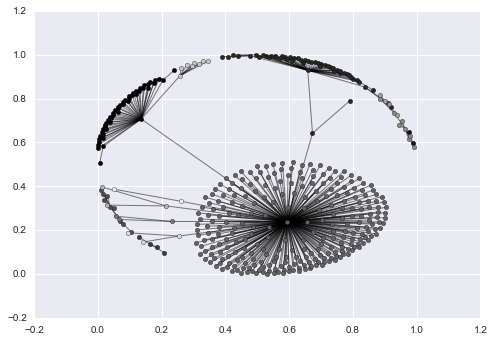

In [172]:
#drawing of the community graph
pos = nx.spring_layout(communityGraph)

for comNb, com in enumerate(set(partition.values())) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(communityGraph, pos, list_nodes, node_size = 20,
                                node_color = str((comNb + 0.0) / totalNbCommunities), cmap=plt.cm.viridis)


nx.draw_networkx_edges(communityGraph,pos, alpha=0.5)
plt.show()

We can use the cleaned email text from before. We add it to the df_emails dataframe.

The advantage is that the cleaned email text already is preprocessed (e.g. tokenized).

In [202]:
#df_emails['cleanedText'] = df_emails_sentiment['email text']


# same method as above, but for general df
def get_clean_mails(df):
    mails = []
    topics = df.ExtractedSubject.values
    contents = df.ExtractedBodyText.values
    n = len(contents)
    print(n)
    for i in range(n):
        if (pd.isnull(topics[i])):
            text = str(contents[i])
        elif(pd.isnull(contents[i])):
            text = str(topics[i])
        else:
            text = str(topics[i]) + ' ' + str(contents[i])
        
        # Tokenization
        tokens = nltk.regexp_tokenize(text, pattern='\w+')

        # Normalization
        tokens = [t.lower() for t in tokens]
        text = text.replace('\n', ' ')
        text = text.replace('\'', '"')

        # Removing the numbers
        tokens = [t for t in tokens if t.isdigit() == False]
        
        # Removing stop words
        tokens = [t for t in tokens if t not in stop_words]
        
        mails.append(tokens)
    
    return mails

In [197]:
df_emails['tokens'] = get_clean_mails(df_emails)

7945


In [199]:
df_emails.head(2)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText,cleanedText,tokens
0,1,C05739545,WOW,H,"Sullivan, Jacob J",87,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,...,,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,,UNCLASSIFIED\nU.S. Department of State\nCase N...,[wow],[wow]
1,2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,,,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,...,,,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...,"[thursday, march, latest, syria, aiding, qadda...","[thursday, march, latest, syria, aiding, qadda..."


In [200]:
#df_emails['cleanedText'].str.cat()

#def getTokensFromEmail(df):
#    tokens = []
#    for rowIdx, row in df.iterrows():
#        cleanText = row['cleanedText']
#        tokens.extend(cleanText.split(" "))
#    return tokens
#        
#len(getTokensFromEmail(df_emails.head(1000)))

#all_tokens = getTokensFromEmail(df_emailsFromCommunity)

In [216]:
import operator


for comNb, com in enumerate(set(partition.values())) :
    personIdsInCommunity = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    
    #df_emails_sentiment['email text'] contains the cleaned email text
    df_emailsFromCommunity = df_emails[df_emails['SenderPersonId'].isin(personIdsInCommunity)]
    
    dictionaryTokens, corpus = get_dictionary_and_corpus(df_emailsFromCommunity['tokens'].values)
    
    #print(dictionaryTokens)
    
    mostCommonTokensWithCount = sorted(dictionaryTokens.iteritems(), key=operator.itemgetter(1))[:20]
    #print(mostCommonTokensWithCount)
    #counterTokens = collections.Counter(dictionaryTokens)
    #mostCommonTokensWithCount = counterTokens.most_common(20)
    mostCommonWords = list(map(lambda elem: elem[1], mostCommonTokensWithCount))
    
    print("Community {} most frequent words: {}".format(comNb, mostCommonWords))
    
    #display_ldamodel(dictionary, corpus, num_topics=5)
    #break
    
#df_emailsFromCommunity.head(2)

Community 0 most frequent words: ['00am', '00pm', '100m', '10am', '10pm', '11am', '11th', '12th', '15pm', '1990s', '1pm', '1st', '20m', '20pm', '21st', '25am', '2pm', '30am', '30pm', '3pm']
Community 1 most frequent words: []
Community 2 most frequent words: ['11th', '13th', '15th', '17th', '18th', '1980s', '1990s', '19th', '1st', '200m', '20s', '21st', '22nd', '30s', '30th', '31st', '35th', '50k', '6m', '8th']
Community 3 most frequent words: ['21st', 'abbas', 'abedin', 'ability', 'able', 'abroad', 'absolutely', 'abu', 'accept', 'accommodate', 'accomplish', 'according', 'accountable', 'achieve', 'achievement', 'achieving', 'act', 'action', 'actors', 'actually']
Community 4 most frequent words: ['00144feabdc0', '03d', '100k', '10th', '11df', '11th', '120x600', '13m', '14th', '15th', '16th', '1920s', '1930s', '1950s', '1960s', '1970s', '1980s', '198os', '1990s', '19th']
Community 5 most frequent words: ['00am', '00pm', '10am', '10pm', '10th', '11am', '11th', '14th', '15am', '15pm', '15t

We see the most frequently occurring tokens are mainly numbers.

In [ ]:
#### TODO: conclusion compare to topic modelling